Initial ideas:
- feature joining last transaction data with current one (time of purchase, location)
- additional info based on the location of the transaction - if previous purchase was made in Portugal 2h ago, is it possible that the current one is made in Poland? probably not

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
df_transactions = pd.read_json('transactions.json', lines=True)
df_users = pd.read_csv('users.csv')
df_merchants = pd.read_csv('merchants.csv')

In [43]:
df_transactions.head(1)

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,is_international,session_length_seconds,is_first_time_merchant,is_fraud
0,TX000000,2022-06-17 23:28:00,U14804,M0314,130.03,in-store,EUR,Android,"{'lat': 40.057938, 'long': 14.959737}",debit_card,1,145,0,0


In [44]:
df_merchants.head(1)

,merchant_id,category,country,trust_score,number_of_alerts_last_6_months,avg_transaction_amount,account_age_months,has_fraud_history
0,M0001,travel,Austria,1.0,3,97.23,84,0


In [45]:
df_users.head(1)

,user_id,age,sex,education,primary_source_of_income,sum_of_monthly_installments,sum_of_monthly_expenses,country,signup_date,risk_score
0,U00001,56,Other,High School,Employment,477.69,243.18,Finland,2021-04-01,0.571079


## 🕒 Temporal Features

| Feature Name                                | Format             | Use-Case                                                                 |
|--------------------------------------------|--------------------|--------------------------------------------------------------------------|
| hour of day                                 | Integer (0–23)     | Captures time-of-day behavior; useful for detecting night-time fraud     |
| day of week                                 | Integer (0–6)      | Weekly behavioral patterns; certain days may have higher fraud rates     |
| is weekend                                  | Boolean            | Distinguishes weekend activity; weekends often have different behavior   |
| month of transaction                        | Integer (1–12)     | Seasonal trends; useful for detecting periodic fraud campaigns           |
| time since last transaction - user-level    | Float (seconds)    | Captures user activity frequency; useful for behavioral profiling        |
| time since last transaction - merchant-level| Float (seconds)    | Captures merchant popularity; good for modeling merchant-specific fraud  |
| time since last user-merchant interaction   | Float (seconds)    | Detects anomalies in specific user-merchant interaction patterns         |

---

## 📊 Spatial Features

In [46]:
# --------- Temporal data feature engineering

df_transactions['hour'] = df_transactions['timestamp'].dt.hour
df_transactions['day_of_week'] = df_transactions['timestamp'].dt.dayofweek  # 0=Monday
df_transactions['is_weekend'] = df_transactions['day_of_week'] >= 5
df_transactions['month'] = df_transactions['timestamp'].dt.month

# Time Since Last Transaction: User-level
df_transactions = df_transactions.sort_values(['user_id', 'timestamp'])
df_transactions['time_since_last_user_txn'] = (
    df_transactions.groupby('user_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

# Time Since Last Transaction: Merchant-level
df_transactions = df_transactions.sort_values(['merchant_id', 'timestamp'])
df_transactions['time_since_last_merchant_txn'] = (
    df_transactions.groupby('merchant_id')['timestamp']
    .diff()
    .dt.total_seconds()
)

#TODO: time since last transaction: user-merchant level

In [47]:
# --------- Geo-data feature engineering
# Extract latitude and longitude into separate columns
df_transactions['latitude'] = df_transactions['location'].apply(lambda x: x['lat'])
df_transactions['longitude'] = df_transactions['location'].apply(lambda x: x['long'])
df_transactions.drop(columns=['location'], inplace=True)

### To Be Continued...

df_transactions.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,payment_method,is_international,...,is_first_time_merchant,is_fraud,hour,day_of_week,is_weekend,month,time_since_last_user_txn,time_since_last_merchant_txn,latitude,longitude
140364,TX140364,2022-01-02 12:10:00,U08165,M0001,30.22,in-store,EUR,Android,credit_card,1,...,1,0,12,6,True,1,NaN,NaN,67.627756,21.454305
193565,TX193565,2022-01-02 18:47:00,U15044,M0001,72.30,in-store,EUR,Android,mobile_payment,1,...,1,0,18,6,True,1,NaN,23820.0,69.229369,22.964022
416618,TX416618,2022-01-04 05:25:00,U14129,M0001,92.05,online,EUR,Android,debit_card,1,...,0,0,5,1,False,1,NaN,124680.0,40.468651,14.784945
461100,TX461100,2022-01-05 01:42:00,U10192,M0001,7.57,in-store,EUR,Android,bank_transfer,1,...,0,0,1,2,False,1,NaN,73020.0,65.759649,-8.348409
324183,TX324183,2022-01-05 21:38:00,U12936,M0001,52.13,mobile,EUR,Android,debit_card,1,...,1,0,21,2,False,1,NaN,71760.0,49.963953,37.133362


##### The idea is to calclate euclidan distance between the current and previous transaction and than divide it by the amount of secnods that passed or smt like that

##### First reverse geocoding to also get the data of where the transaction happend so we can flag places such as the ocean as suspicious

<Axes: >

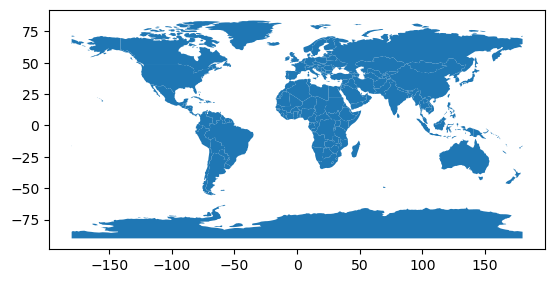

In [48]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
world.plot()

### Doing it for 500 as if you plot too many its just a giant red square

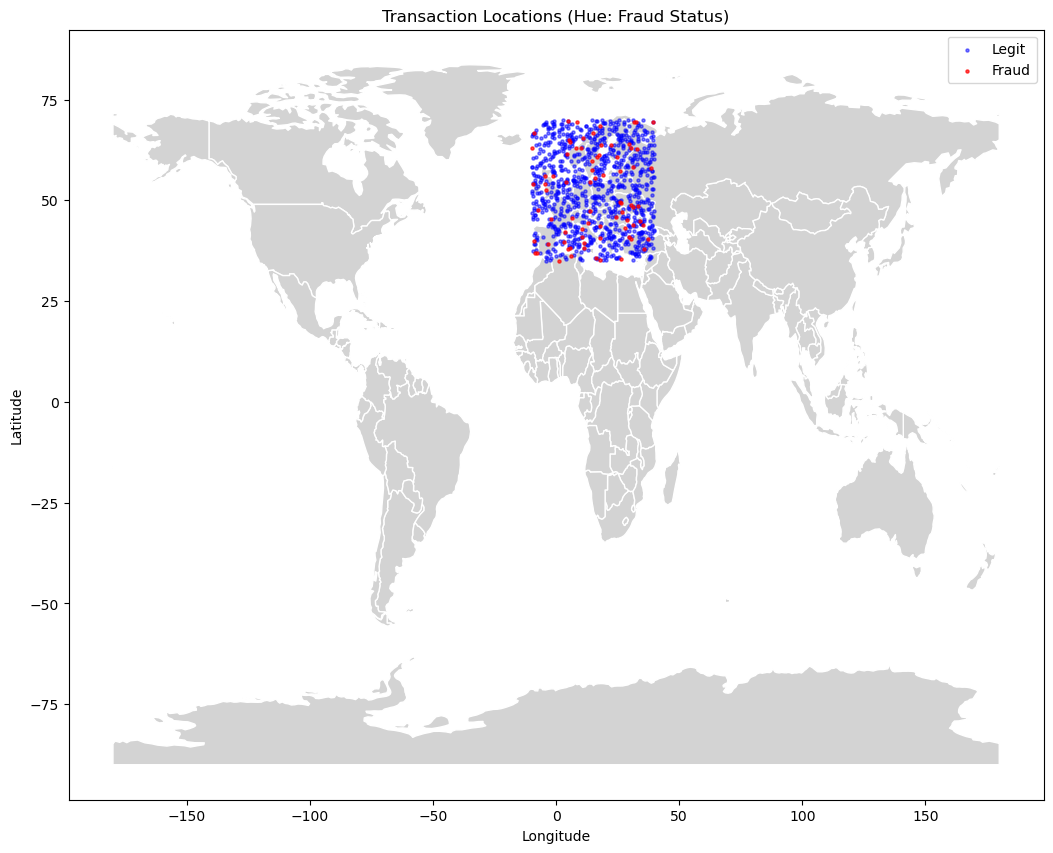

In [53]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Geometry
geometry = [Point(xy) for xy in zip(df_transactions.head(1000)['longitude'], df_transactions.head(1000)['latitude'])]
gdf_points = gpd.GeoDataFrame(df_transactions.head(1000), geometry=geometry, crs="EPSG:4326")


world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")

#split by fraud
gdf_fraud = gdf_points[gdf_points['is_fraud'] == 1]
gdf_legit = gdf_points[gdf_points['is_fraud'] == 0]


fig, ax = plt.subplots(figsize=(16, 10))
world.plot(ax=ax, color='lightgray', edgecolor='white')


gdf_legit.plot(ax=ax, color='blue', markersize=5, alpha=0.5, label='Legit')


gdf_fraud.plot(ax=ax, color='red', markersize=5, alpha=0.7, label='Fraud')

plt.title("Transaction Locations (Hue: Fraud Status)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()

### Everything is in Europe basicly but there are some obs on the ocean and a few in Africa maybe they can be flagged

In [55]:
print(oceans.columns)

Index(['scalerank', 'featurecla', 'min_zoom', 'geometry'], dtype='object')


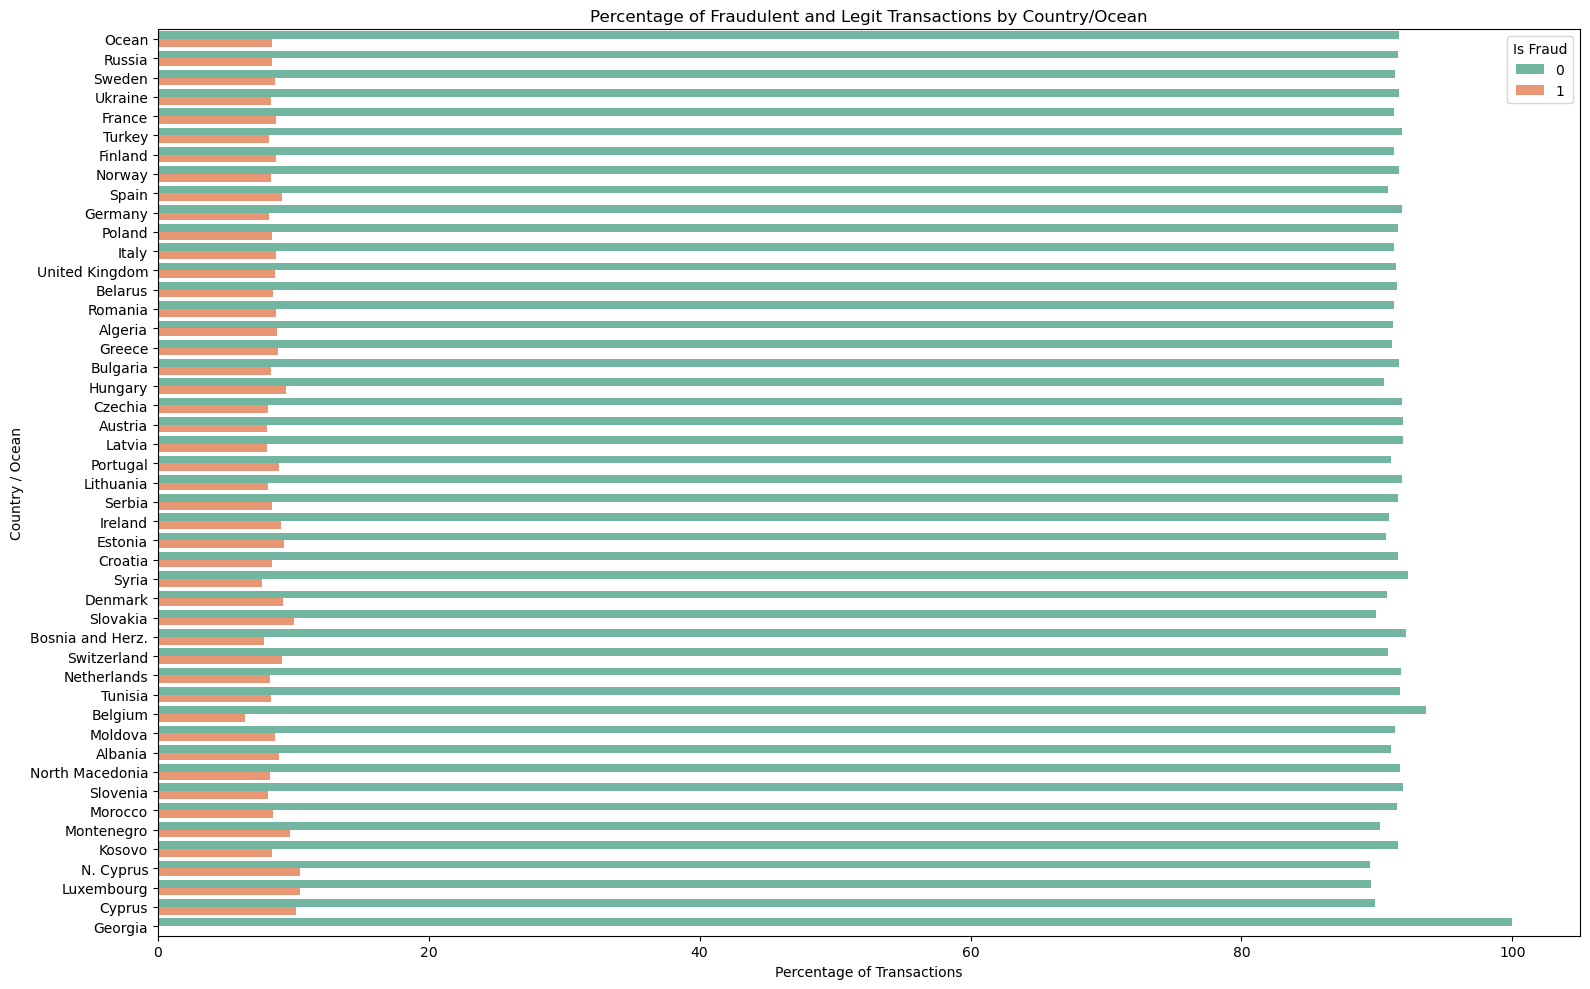

In [60]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import seaborn as sns


geometry = [Point(xy) for xy in zip(df_transactions['longitude'], df_transactions['latitude'])]
gdf_points = gpd.GeoDataFrame(df_transactions.copy(), geometry=geometry, crs="EPSG:4326")


world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
oceans = gpd.read_file("https://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip")


gdf_country = gpd.sjoin(gdf_points, world[['geometry', 'NAME']], how='left', predicate='within')
gdf_country.rename(columns={'NAME': 'country'}, inplace=True)


gdf_na = gdf_country[gdf_country['country'].isna()].copy()

# So the joins work
gdf_na = gdf_na.drop(columns=[col for col in ['index_right'] if col in gdf_na.columns])
oceans = oceans.drop(columns=[col for col in ['index_right'] if col in oceans.columns])


gdf_ocean = gpd.sjoin(gdf_na, oceans[['geometry']], how='left', predicate='within')


gdf_country.loc[gdf_ocean.index, 'country'] = 'Ocean'


grouped = gdf_country.groupby(['country', 'is_fraud']).size().reset_index(name='count')


grouped['percent'] = grouped.groupby('country')['count'].transform(lambda x: 100 * x / x.sum())


country_order = gdf_country['country'].value_counts().index.tolist()


plt.figure(figsize=(16, 10))
sns.barplot(data=grouped, y='country', x='percent', hue='is_fraud', palette='Set2', order=country_order)
plt.title('Percentage of Fraudulent and Legit Transactions by Country/Ocean')
plt.xlabel('Percentage of Transactions')
plt.ylabel('Country / Ocean')
plt.legend(title='Is Fraud')
plt.tight_layout()
plt.show()


### Jak ktoś z was umie dobrze kodować to porawcie bo ten kod jest opór chujowo napisany i połowa z chatem xd
